In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import PerceiverAREstimator

In [3]:
dataset = get_dataset("electricity")

In [4]:
estimator = PerceiverAREstimator(
    depth=2,
    heads=2,
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*10,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1,),
)

In [5]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.test,
    num_workers=8,
    shuffle_buffer_length=4000,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PerceiverARModel | 55.3 K
-------------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 5.44867 (best 5.44867), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_32/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 5.35806 (best 5.35806), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/perceiverar/lightning_logs/version_32/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


ValueError: Expected parameter df (Tensor of shape (128, 24)) of distribution Chi2() to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [20]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [21]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))


Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 4768.58it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [22]:
agg_metrics

{'MSE': 2632277.5637280988,
 'abs_error': 8510987.796981812,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6778296899315452,
 'MAPE': 0.08927172247730361,
 'sMAPE': 0.09760858887603995,
 'MSIS': 5.672968862545339,
 'QuantileLoss[0.1]': 3457375.6345648617,
 'Coverage[0.1]': 0.08778371161548731,
 'QuantileLoss[0.2]': 5534597.8590742415,
 'Coverage[0.2]': 0.17855288532858626,
 'QuantileLoss[0.3]': 6996813.588530006,
 'Coverage[0.3]': 0.2765353805073431,
 'QuantileLoss[0.4]': 7983532.04939911,
 'Coverage[0.4]': 0.3759827918706424,
 'QuantileLoss[0.5]': 8510987.873387918,
 'Coverage[0.5]': 0.48075211392968403,
 'QuantileLoss[0.6]': 8669924.372969786,
 'Coverage[0.6]': 0.5748405281115562,
 'QuantileLoss[0.7]': 8253363.577501401,
 'Coverage[0.7]': 0.6788310339712208,
 'QuantileLoss[0.8]': 7247401.984374037,
 'Coverage[0.8]': 0.7797804480047471,
 'QuantileLoss[0.9]': 5274768.110512937,
 'Coverage[0.9]': 0.88102655392375

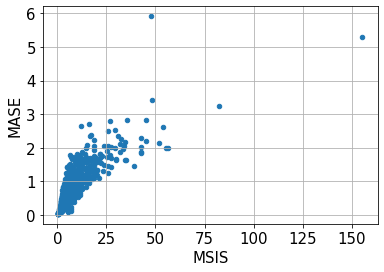

In [23]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

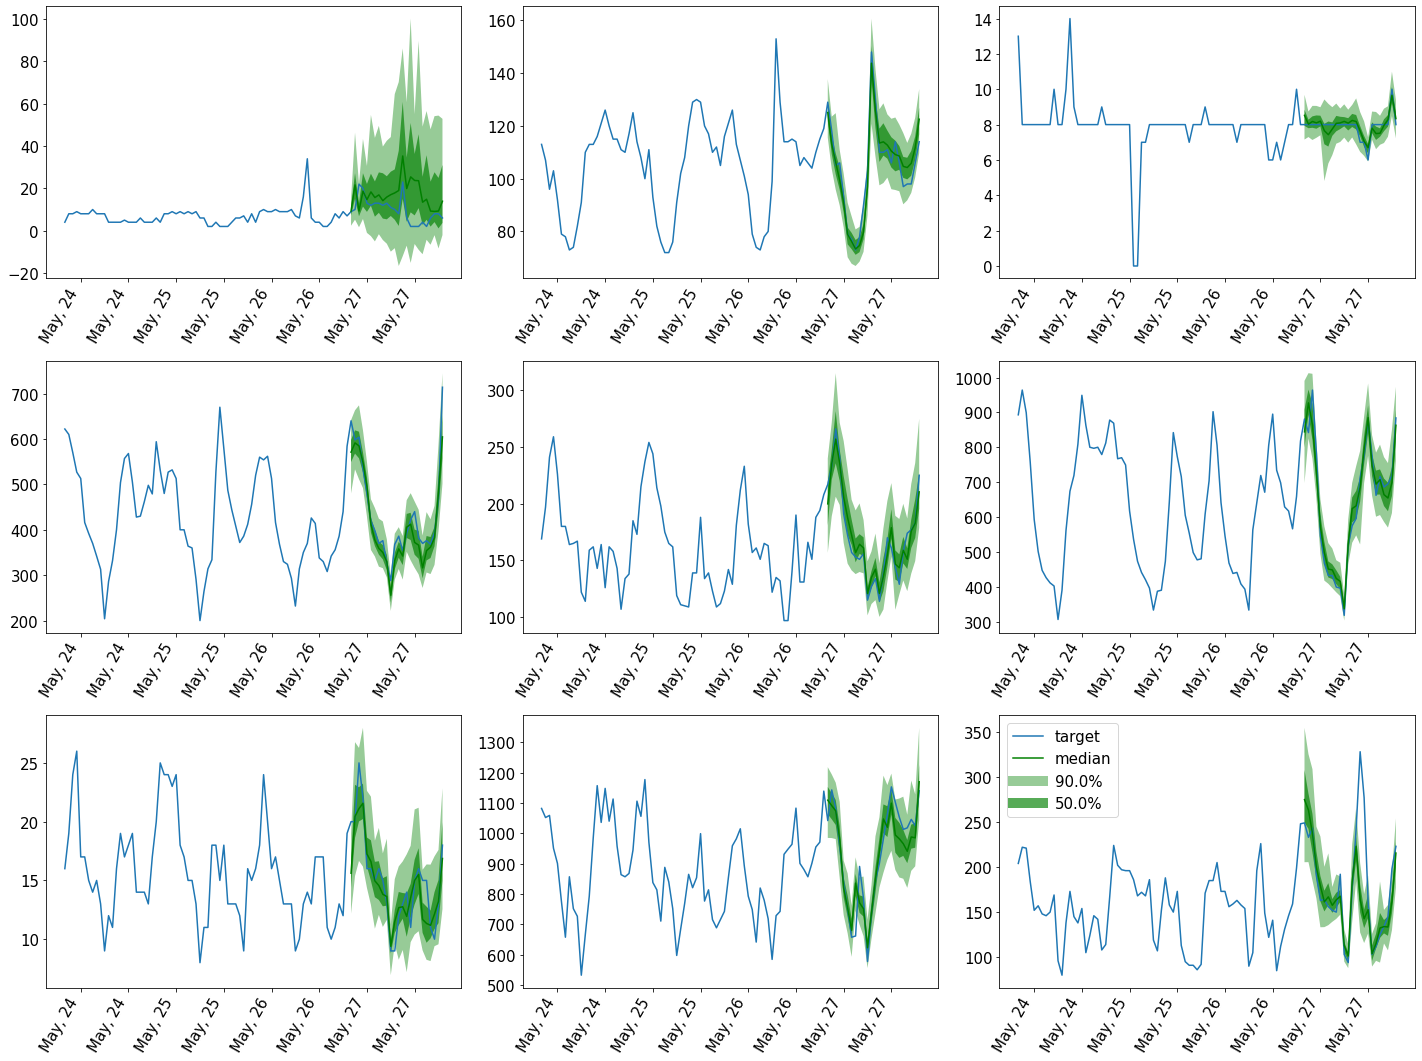

In [24]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()